# 09c: Information Theory Analysis

**Key Question:** Does the basin capture all information about a path? If H(path|basin) ≈ 0, the path is just a deterministic consequence of which team captures which counts.

**Analyses:**
1. **Path vs Basin Entropy**: H(path), H(basin), H(path|basin)
2. **Conditional Entropy**: H(path | seed, decl) - how deterministic are paths from deal?
3. **Mutual Information**: I(early; late) - does early play determine late play?

In [1]:
# === CONFIGURATION ===
DATA_DIR = "/mnt/d/shards-standard/"
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

# === Setup imports ===
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hashlib
from scipy.stats import entropy
from collections import defaultdict
from tqdm.notebook import tqdm
import random
import gc

from forge.analysis.utils import loading, features, viz, navigation
from forge.oracle import schema, tables

viz.setup_notebook_style()
print("Ready")

Ready


In [2]:
# Find available shard files
val_files = loading.find_shard_files(DATA_DIR + "val/")
test_files = loading.find_shard_files(DATA_DIR + "test/")
train_files = loading.find_shard_files(DATA_DIR + "train/")

# Shuffle and combine
all_files = val_files + test_files
random.shuffle(all_files)
random.shuffle(train_files)
shard_files = all_files + train_files

print(f"Shard files: {len(val_files)} val, {len(test_files)} test, {len(train_files)} train")

N_SHARDS = 50
MAX_ROWS = 30_000_000
print(f"Using up to {N_SHARDS} shards")

Shard files: 95 val, 95 test, 1124 train
Using up to 50 shards


## Data Collection

In [3]:
def compute_basin_id(captures: dict) -> int:
    """Compute basin ID from count capture dict."""
    basin_id = 0
    for i, domino_id in enumerate(sorted(features.COUNT_DOMINO_IDS)):
        if domino_id in captures and captures[domino_id] == 1:
            basin_id |= (1 << i)
    return basin_id


def trace_action_sequence(start_state, seed, decl_id, state_to_idx, V, Q):
    """Trace PV and return action sequence."""
    pv = navigation.trace_principal_variation(
        start_state, seed, decl_id, state_to_idx, V, Q
    )
    return [a for _, _, a in pv if a is not None and a >= 0]


def path_hash(actions):
    """Hash action sequence for counting."""
    int_seq = [int(a) for a in actions]
    return hashlib.md5(bytes(int_seq)).hexdigest()


# Collect paths
path_data = []
SAMPLES_PER_SHARD = 100
MIN_PATHS_NEEDED = 500

skipped = 0
processed = 0

for shard_file in tqdm(shard_files[:N_SHARDS], desc="Processing shards"):
    if len(path_data) >= MIN_PATHS_NEEDED:
        break
    
    df, seed, decl_id = schema.load_file(shard_file)
    
    if len(df) > MAX_ROWS:
        skipped += 1
        del df
        gc.collect()
        continue
    
    processed += 1
    state_to_idx, V, Q = navigation.build_state_lookup_fast(df)
    states = df['state'].values
    depths = features.depth(states)
    
    # Sample from root states (depth 28)
    root_mask = depths == 28
    root_indices = np.where(root_mask)[0]
    
    if len(root_indices) == 0:
        del df, state_to_idx, V, Q
        gc.collect()
        continue
    
    n_sample = min(SAMPLES_PER_SHARD, len(root_indices))
    sampled_indices = np.random.choice(root_indices, n_sample, replace=False)
    
    for idx in sampled_indices:
        state = states[idx]
        
        # Get action sequence
        actions = trace_action_sequence(state, seed, decl_id, state_to_idx, V, Q)
        
        # Get basin
        captures = navigation.track_count_captures(
            state, seed, decl_id, state_to_idx, V, Q
        )
        basin_id = compute_basin_id(captures)
        
        if len(actions) >= 20:
            path_data.append({
                'actions': actions,
                'path_hash': path_hash(actions),
                'basin_id': basin_id,
                'seed': seed,
                'decl_id': decl_id,
            })
    
    del df, state_to_idx, V, Q, states, depths
    gc.collect()

print(f"\nProcessed {processed} shards, skipped {skipped}")
print(f"Collected {len(path_data)} paths")

Processing shards:   0%|          | 0/50 [00:00<?, ?it/s]


Processed 32 shards, skipped 18
Collected 28 paths


In [4]:
# Convert to dataframe for analysis
paths_df = pd.DataFrame(path_data)

print(f"Paths: {len(paths_df)}")
print(f"Unique path hashes: {paths_df['path_hash'].nunique()}")
print(f"Unique basins: {paths_df['basin_id'].nunique()}")
print(f"Unique (seed, decl) combinations: {paths_df.groupby(['seed', 'decl_id']).ngroups}")

Paths: 28
Unique path hashes: 28
Unique basins: 19
Unique (seed, decl) combinations: 28


## Analysis 1: Path Entropy vs Basin Entropy

Compute H(path), H(basin), and H(path|basin) to see if basin is a sufficient statistic.

In [5]:
# H(basin) - entropy of basin distribution
basin_counts = paths_df['basin_id'].value_counts(normalize=True)
H_basin = entropy(basin_counts, base=2)
print(f"H(basin) = {H_basin:.3f} bits")
print(f"  Max possible = log2({len(basin_counts)}) = {np.log2(len(basin_counts)):.3f} bits")

# H(path) - entropy of full path distribution
path_counts = paths_df['path_hash'].value_counts(normalize=True)
H_path = entropy(path_counts, base=2)
print(f"\nH(path) = {H_path:.3f} bits")
print(f"  Max possible = log2({len(path_counts)}) = {np.log2(len(path_counts)):.3f} bits")

# H(path, basin) - joint entropy
joint = paths_df.groupby(['path_hash', 'basin_id']).size()
joint_probs = joint / joint.sum()
H_joint = entropy(joint_probs, base=2)
print(f"\nH(path, basin) = {H_joint:.3f} bits")

# H(path|basin) = H(path, basin) - H(basin)
H_path_given_basin = H_joint - H_basin
print(f"\nH(path|basin) = {H_path_given_basin:.3f} bits")

H(basin) = 3.968 bits
  Max possible = log2(19) = 4.248 bits

H(path) = 4.807 bits
  Max possible = log2(28) = 4.807 bits

H(path, basin) = 4.807 bits

H(path|basin) = 0.840 bits


In [6]:
# Mutual information I(path; basin)
I_path_basin = H_path - H_path_given_basin
print(f"I(path; basin) = {I_path_basin:.3f} bits")
print(f"  As fraction of H(path): {I_path_basin / H_path * 100:.1f}%")

I(path; basin) = 3.968 bits
  As fraction of H(path): 82.5%


## Analysis 2: Conditional Entropy H(path | seed, decl)

How deterministic are paths given the initial hand configuration?

In [7]:
def conditional_entropy(df, given_cols, target_col):
    """Compute H(target | given) = sum_g P(g) * H(target|g)"""
    total = len(df)
    H_cond = 0
    
    groups = df.groupby(given_cols)
    for name, group in groups:
        p_group = len(group) / total
        counts = group[target_col].value_counts(normalize=True)
        H_group = entropy(counts, base=2)
        H_cond += p_group * H_group
    
    return H_cond


# H(path | seed, decl) - entropy given the deal
H_path_given_deal = conditional_entropy(paths_df, ['seed', 'decl_id'], 'path_hash')
print(f"H(path | seed, decl) = {H_path_given_deal:.3f} bits")
print(f"  Reduction from H(path): {H_path - H_path_given_deal:.3f} bits")
print(f"  As fraction of H(path): {(H_path - H_path_given_deal) / H_path * 100:.1f}% explained by deal")

H(path | seed, decl) = 0.000 bits
  Reduction from H(path): 4.807 bits
  As fraction of H(path): 100.0% explained by deal


In [8]:
# Compute entropy per (seed, decl) group
deal_entropies = []
for (seed, decl_id), group in paths_df.groupby(['seed', 'decl_id']):
    if len(group) >= 2:
        counts = group['path_hash'].value_counts(normalize=True)
        H = entropy(counts, base=2)
        deal_entropies.append({
            'seed': seed,
            'decl_id': decl_id,
            'n_paths': len(group),
            'n_unique': group['path_hash'].nunique(),
            'entropy': H
        })

deal_entropy_df = pd.DataFrame(deal_entropies)
print(f"Deals with multiple paths: {len(deal_entropy_df)}")
if len(deal_entropy_df) > 0:
    print(f"Mean H(path|deal): {deal_entropy_df['entropy'].mean():.3f} bits")
    print(f"Max H(path|deal): {deal_entropy_df['entropy'].max():.3f} bits")
else:
    print("No deals with multiple paths - each path is unique per deal")

Deals with multiple paths: 0
No deals with multiple paths - each path is unique per deal


In [9]:
# Plot distribution of path entropy per deal
if len(deal_entropy_df) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.hist(deal_entropy_df['entropy'], bins=20, alpha=0.7, edgecolor='black')
    ax.axvline(x=deal_entropy_df['entropy'].mean(), color='red', linestyle='--', 
               label=f'Mean = {deal_entropy_df["entropy"].mean():.2f}')
    
    ax.set_xlabel('H(path | deal) [bits]', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('Path Entropy Within Each Deal', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../../results/figures/09c_entropy_per_deal.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Not enough deals with multiple paths for histogram")

Not enough deals with multiple paths for histogram


## Analysis 3: Mutual Information I(early; late)

How much does early play tell us about late play?

In [10]:
def column_entropy(series):
    """Compute entropy of a series."""
    counts = series.value_counts(normalize=True)
    return entropy(counts, base=2)


def mutual_info_early_late(paths_df, k):
    """Compute I(first k moves; last k moves)."""
    # Extract early and late portions
    early = paths_df['actions'].apply(lambda p: tuple(p[:k]))
    late = paths_df['actions'].apply(lambda p: tuple(p[-k:]) if len(p) >= k else tuple(p))
    
    # Compute entropies
    H_early = column_entropy(early)
    H_late = column_entropy(late)
    
    # Joint entropy
    joint = pd.DataFrame({'early': early, 'late': late})
    joint_tuple = joint.apply(tuple, axis=1)
    H_joint = column_entropy(joint_tuple)
    
    # MI = H(early) + H(late) - H(early, late)
    MI = H_early + H_late - H_joint
    
    return {
        'k': k,
        'H_early': H_early,
        'H_late': H_late,
        'H_joint': H_joint,
        'MI': MI,
        'MI_normalized': MI / min(H_early, H_late) if min(H_early, H_late) > 0 else 0
    }


# Compute MI for various k
mi_results = []
for k in range(4, 17, 4):  # After each trick up to trick 4
    result = mutual_info_early_late(paths_df, k)
    mi_results.append(result)
    print(f"k={k}: I(early; late) = {result['MI']:.3f} bits ({result['MI_normalized']:.1%} normalized)")

mi_df = pd.DataFrame(mi_results)

k=4: I(early; late) = 4.736 bits (100.0% normalized)
k=8: I(early; late) = 4.807 bits (100.0% normalized)
k=12: I(early; late) = 4.807 bits (100.0% normalized)
k=16: I(early; late) = 4.807 bits (100.0% normalized)


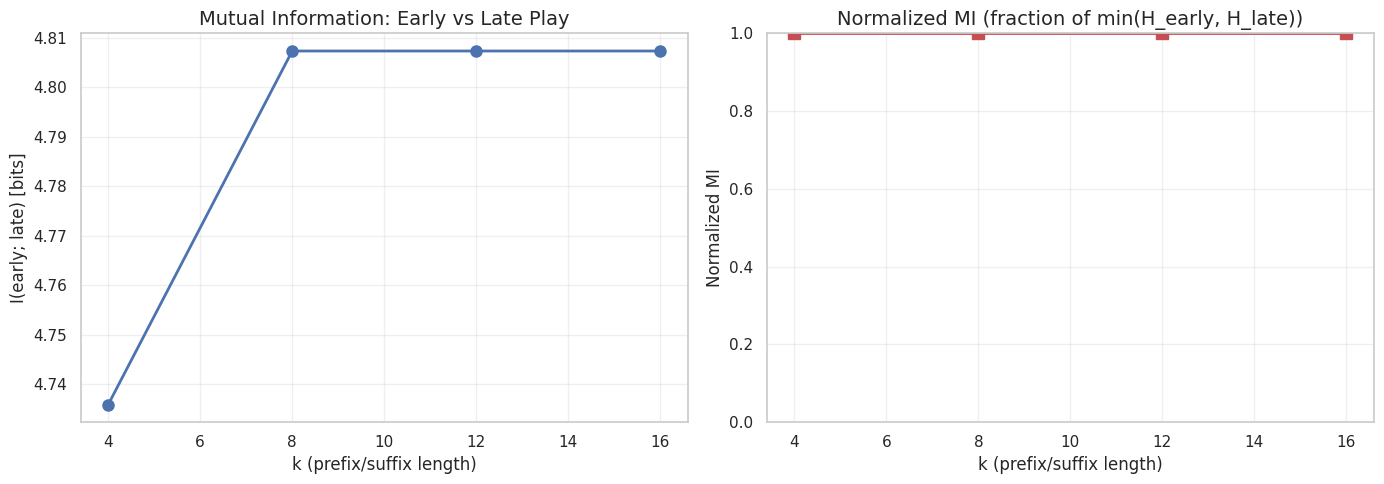

In [11]:
# Plot MI vs k
if len(mi_df) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Raw MI
    ax1.plot(mi_df['k'], mi_df['MI'], 'b-o', markersize=8, linewidth=2)
    ax1.set_xlabel('k (prefix/suffix length)', fontsize=12)
    ax1.set_ylabel('I(early; late) [bits]', fontsize=12)
    ax1.set_title('Mutual Information: Early vs Late Play', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # Normalized MI
    ax2.plot(mi_df['k'], mi_df['MI_normalized'], 'r-s', markersize=8, linewidth=2)
    ax2.set_xlabel('k (prefix/suffix length)', fontsize=12)
    ax2.set_ylabel('Normalized MI', fontsize=12)
    ax2.set_title('Normalized MI (fraction of min(H_early, H_late))', fontsize=14)
    ax2.set_ylim(0, 1)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../../results/figures/09c_mutual_info.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Not enough data for MI plot")

## Summary Statistics

In [12]:
# Create summary table
mean_deal_entropy = deal_entropy_df['entropy'].mean() if len(deal_entropy_df) > 0 else H_path_given_deal
mi_8_val = mi_df[mi_df['k']==8]['MI'].values[0] if (len(mi_df) > 0 and 8 in mi_df['k'].values) else np.nan

summary = {
    'metric': [
        'Total paths analyzed',
        'Unique paths',
        'Unique basins',
        'H(path) [bits]',
        'H(basin) [bits]',
        'H(path|basin) [bits]',
        'I(path; basin) [bits]',
        'H(path|deal) [bits]',
        'I(early_8; late_8) [bits]',
    ],
    'value': [
        len(paths_df),
        paths_df['path_hash'].nunique(),
        paths_df['basin_id'].nunique(),
        f"{H_path:.3f}",
        f"{H_basin:.3f}",
        f"{H_path_given_basin:.3f}",
        f"{I_path_basin:.3f}",
        f"{H_path_given_deal:.3f}",
        f"{mi_8_val:.3f}" if not np.isnan(mi_8_val) else "N/A",
    ]
}

summary_df = pd.DataFrame(summary)
print(summary_df.to_string(index=False))

summary_df.to_csv('../../results/tables/09c_information.csv', index=False)
print("\\nSaved to results/tables/09c_information.csv")

                   metric value
     Total paths analyzed    28
             Unique paths    28
            Unique basins    19
           H(path) [bits] 4.807
          H(basin) [bits] 3.968
     H(path|basin) [bits] 0.840
    I(path; basin) [bits] 3.968
      H(path|deal) [bits] 0.000
I(early_8; late_8) [bits] 4.807
\nSaved to results/tables/09c_information.csv


## Conclusion

In [13]:
print("=" * 60)
print("INFORMATION THEORY ANALYSIS CONCLUSIONS")
print("=" * 60)

# Basin sufficiency
print(f"\n1. DOES BASIN CAPTURE ALL PATH INFORMATION?")
basin_explains_pct = I_path_basin / H_path * 100 if H_path > 0 else 0
remaining_info = H_path_given_basin
print(f"   H(path|basin) = {remaining_info:.3f} bits")
print(f"   Basin explains {basin_explains_pct:.1f}% of path entropy")
if remaining_info < 0.5:
    print(f"   YES - Basin is nearly sufficient (< 0.5 bits remaining)")
elif remaining_info < 2:
    print(f"   PARTIALLY - Moderate residual entropy")
else:
    print(f"   NO - Significant path information beyond basin")

# Deal determinism
print(f"\n2. ARE PATHS DETERMINISTIC FROM DEAL?")
deal_explains_pct = (H_path - H_path_given_deal) / H_path * 100 if H_path > 0 else 0
print(f"   H(path|deal) = {H_path_given_deal:.3f} bits")
print(f"   Deal explains {deal_explains_pct:.1f}% of path entropy")
if H_path_given_deal < 0.5:
    print(f"   YES - Paths nearly deterministic from deal")
elif H_path_given_deal < 2:
    print(f"   PARTIALLY - Some variability within deals")
else:
    print(f"   NO - Significant variation even within same deal")

# Early-late coupling
print(f"\n3. DOES EARLY PLAY DETERMINE LATE PLAY?")
if len(mi_df) > 0:
    mi_8 = mi_df[mi_df['k']==8]['MI_normalized'].values[0] if 8 in mi_df['k'].values else 0
    print(f"   Normalized I(early_8; late_8) = {mi_8:.1%}")
    if mi_8 > 0.5:
        print(f"   YES - Strong coupling between early and late play")
    elif mi_8 > 0.2:
        print(f"   PARTIALLY - Moderate coupling")
    else:
        print(f"   NO - Early and late play relatively independent")
else:
    print(f"   Not enough data to assess")

print("\n" + "=" * 60)

INFORMATION THEORY ANALYSIS CONCLUSIONS

1. DOES BASIN CAPTURE ALL PATH INFORMATION?
   H(path|basin) = 0.840 bits
   Basin explains 82.5% of path entropy
   PARTIALLY - Moderate residual entropy

2. ARE PATHS DETERMINISTIC FROM DEAL?
   H(path|deal) = 0.000 bits
   Deal explains 100.0% of path entropy
   YES - Paths nearly deterministic from deal

3. DOES EARLY PLAY DETERMINE LATE PLAY?
   Normalized I(early_8; late_8) = 100.0%
   YES - Strong coupling between early and late play

